In [51]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from genomics_dl.models import search_best_clustering

In [52]:
DATA_PROCESSED = Path("../data/processed")

DATA_PATH = DATA_PROCESSED /"gse183635_tep_tpm_labels.parquet"
TRAIN_PATH = DATA_PROCESSED / "gse183635_tep_tpm_train.parquet"
TEST_PATH  = DATA_PROCESSED / "gse183635_tep_tpm_test.parquet"

RANDOM_STATE = 42
TEST_SIZE = 0.2

metadata_cols = [
    "Sample ID",
    "Patient_group",
    "Stage",
    "Sex",
    "Age",
    "Sample-supplying institution",
    "Training series",
    "Evaluation series",
    "Validation series",
    "lib.size",
    "classificationScoreCancer",
    "Class_group",
]

In [53]:
df = pd.read_parquet(DATA_PATH)

if "Sample ID" in df.columns:
    df = df.set_index("Sample ID", drop=False)


gene_cols = [c for c in df.columns if c not in metadata_cols]

X_all = df[gene_cols]        # matriz de expresión 
meta_all = df[metadata_cols] # metadatos


# EDA poblacional básico

## Tamaños y clases

In [54]:
print("N muestras:", len(df))
print("\nDistribución por Class_group")
print(meta_all["Class_group"].value_counts(dropna=False))

print("\nDistribución por Patient_group")
print(meta_all["Patient_group"].value_counts(dropna=False))

N muestras: 2351

Distribución por Class_group
Class_group
Malignant       1628
nonMalignant     723
Name: count, dtype: int64

Distribución por Patient_group
Patient_group
Non-small-cell lung cancer        522
Asymptomatic controls             390
Ovarian cancer                    144
Glioma                            132
Pancreatic cancer                 126
Head and neck cancer              101
Breast cancer                      93
Multiple sclerosis                 86
Cholangiocarcinoma                 85
Colorectal cancer                  85
Pulmonary Hypertension             72
Melanoma                           68
Sarcoma                            53
Pancreatic diseases                50
Medically-intractable epilepsy     44
Endometrial cancer                 39
Prostate cancer                    35
Multiple Myeloma                   31
Renal cell cancer                  28
Urothelial cancer                  28
Former sarcoma                     26
Angina pectoris              

In [55]:
print("\nDistribución por Stage")
print(meta_all["Stage"].value_counts(dropna=False))



Distribución por Stage
Stage
n.a.    978
IV      861
III     235
II      166
I       111
Name: count, dtype: int64


## Edad, sexo, institución

In [56]:
print("\nResumen edad")
print(meta_all["Age"].describe())

print("\nDistribución por Sex")
print(meta_all["Sex"].value_counts(dropna=False))


Resumen edad
count    2328.000000
mean       58.490550
std        14.137847
min        18.000000
25%        51.000000
50%        61.000000
75%        69.000000
max        92.000000
Name: Age, dtype: float64

Distribución por Sex
Sex
F       1220
M       1111
n.a.      20
Name: count, dtype: int64


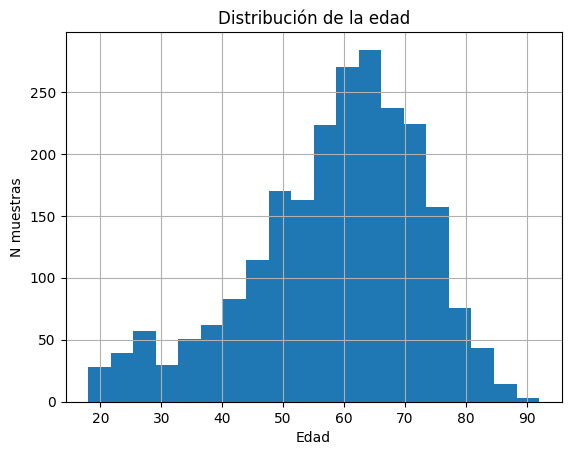

In [57]:
meta_all["Age"].hist(bins=20)
plt.xlabel("Edad")
plt.ylabel("N muestras")
plt.title("Distribución de la edad")
plt.grid(True)
plt.show()


# Split train/test estratificado

In [58]:
y_all = meta_all["Class_group"]

train_idx, test_idx = train_test_split(
    df.index,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_all # balanceado
)

print("Train:", len(train_idx), "Test:", len(test_idx))


Train: 1880 Test: 471


In [59]:
df_train = df.loc[train_idx].copy()
df_test  = df.loc[test_idx].copy()


df_train.to_parquet(TRAIN_PATH, index=False)
df_test.to_parquet(TEST_PATH, index=False)

# Guardar solo los IDs para trazabilidad
REF_PATH = DATA_PROCESSED / "gse183635_split_indices.csv"
pd.DataFrame({
    "Sample ID": df.index,
    "split": np.where(df.index.isin(train_idx), "train", "test")
}).to_csv(REF_PATH, index=False)


# Estudio de heterogeneidad en nonMalignant

In [60]:
df_train = pd.read_parquet(TRAIN_PATH)
df_train = df_train.set_index("Sample ID", drop=False)

meta_train = df_train[metadata_cols].copy()
gene_cols = [c for c in df_train.columns if c not in metadata_cols]
X_train = df_train[gene_cols]

mask_nonmal = meta_train["Class_group"] == "nonMalignant"
X_nm = X_train[mask_nonmal]
meta_nm = meta_train[mask_nonmal]

print("N nonMalignant en train:", X_nm.shape)

N nonMalignant en train: (578, 5440)


In [61]:
# Filtrar genes con muy baja varianza

#var = X_nm.var(axis=0)
#var_threshold = np.percentile(var, 10)
#high_var_genes = var[var > var_threshold].index

#X_nm_hv = X_nm[high_var_genes]

X_nm_log = np.log1p(X_nm) #X_nm_hv

scaler = StandardScaler()
X_nm_scaled = scaler.fit_transform(X_nm_log)

## PCA
**Auto-seleccionado**

TPM -> filtrado genes -> log -> escalado -> PCA -> UMAP



Número de componentes para >= 90% de varianza: 268
Varianza explicada acumulada real con 268 PCs: 0.9002535439115626


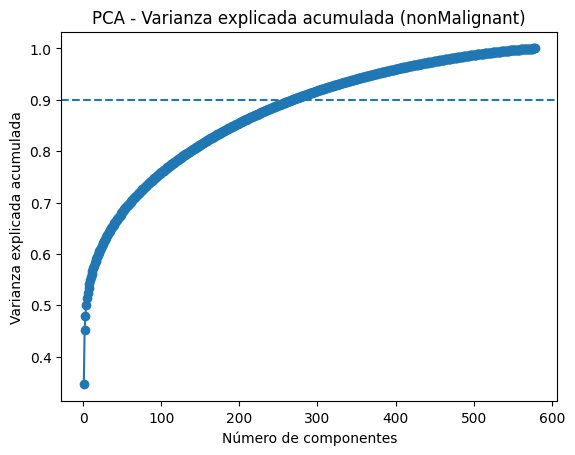

In [62]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_nm_scaled)

var_ratio = pca_full.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

threshold = 0.90
n_components = int(np.searchsorted(cum_var_ratio, threshold) + 1)

print(f"\nNúmero de componentes para >= {threshold*100:.0f}% de varianza:",
      n_components)
print(f"Varianza explicada acumulada real con {n_components} PCs:",
      cum_var_ratio[n_components - 1])

plt.figure()
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, marker="o")
plt.axhline(threshold, linestyle="--")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA - Varianza explicada acumulada (nonMalignant)")
plt.show()

In [63]:
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_nm_scaled)

print("Shape de X_pca:", X_pca.shape)

Shape de X_pca: (578, 268)


## UMAP

In [64]:
#  UMAP sobre las componentes principales 

def compute_umap_from_pca(
    X_pca,
    n_neighbors=15,
    min_dist=0.3,
    random_state=42
):
    """
    Aplica UMAP sobre el espacio PCA.
    X_pca: array (n_samples, n_components_pca)
    Devuelve: X_umap (n_samples, 2)
    """
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=random_state,
    )
    X_umap = umap_model.fit_transform(X_pca)
    return X_umap, umap_model



In [65]:
X_umap, umap_model = compute_umap_from_pca(
    X_pca,
    n_neighbors=15,
    min_dist=0.3,
    random_state=RANDOM_STATE,
)

print("Shape UMAP:", X_umap.shape)

/workspaces/TFM/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape UMAP: (578, 2)


In [66]:
def plot_umap(
    X_umap,
    color=None,
    title="UMAP",
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    cmap=None
):
    """
    X_umap: array (n_samples, 2)
    color: vector o serie para colorear puntos (opcional)
    """
    plt.figure()
    scatter = plt.scatter(
        X_umap[:, 0],
        X_umap[:, 1],
        c=color,
        alpha=0.7,
        cmap=cmap,
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if color is not None:
        plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()


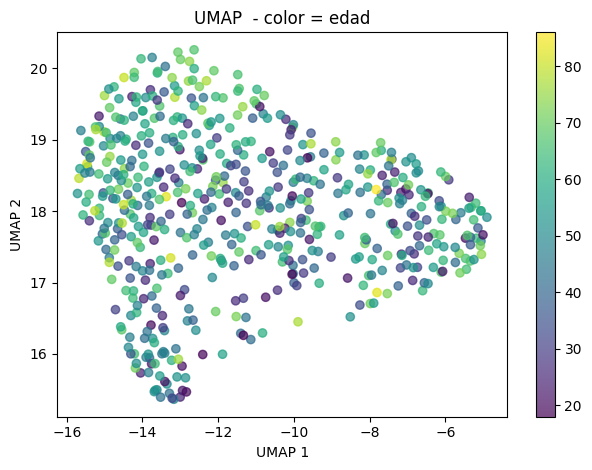

In [67]:
plot_umap(
    X_umap,
    color=meta_nm["Age"],
    title="UMAP  - color = edad"
)

## CLUSTERING

In [68]:
best_clust, df_clust_results, all_clust_results = search_best_clustering(
    X_pca,
    n_clusters_range=range(2, 11),
    random_state=RANDOM_STATE,
)

print("Mejor algoritmo:", best_clust["modelo"])
print("Mejor número de clusters:", best_clust["n_clusters"])
print("Silhouette:", best_clust["silhouette"])

labels_best = best_clust["labels"]
meta_nm["cluster_auto"] = labels_best


n=2 | kmeans sil=0.282, gmm sil=0.282, agg_ward sil=0.261 
n=3 | kmeans sil=0.142, gmm sil=0.142, agg_ward sil=0.203 
n=4 | kmeans sil=0.146, gmm sil=0.146, agg_ward sil=0.162 
n=5 | kmeans sil=0.145, gmm sil=0.145, agg_ward sil=0.122 
n=6 | kmeans sil=0.145, gmm sil=0.145, agg_ward sil=0.120 
n=7 | kmeans sil=0.143, gmm sil=0.143, agg_ward sil=0.099 
n=8 | kmeans sil=0.089, gmm sil=0.089, agg_ward sil=0.050 
n=9 | kmeans sil=0.065, gmm sil=0.065, agg_ward sil=0.053 
n=10 | kmeans sil=0.064, gmm sil=0.064, agg_ward sil=0.045 

Mejor configuración:
{'modelo': 'kmeans', 'n_clusters': 2, 'params': {'n_clusters': 2}, 'silhouette': 0.28160618092705103, 'calinski_harabasz': 229.7555187531496, 'davies_bouldin': 1.3871018905323027}
Mejor algoritmo: kmeans
Mejor número de clusters: 2
Silhouette: 0.28160618092705103


/tmp/ipykernel_39139/3473811383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_nm["cluster_auto"] = labels_best


In [69]:
meta_nm["cluster_auto"].value_counts()

cluster_auto
0    385
1    193
Name: count, dtype: int64

In [70]:
pd.crosstab(meta_nm["cluster_auto"], meta_nm["Sex"])

Sex,F,M,n.a.
cluster_auto,,,
0,208,167,10
1,111,81,1


In [71]:
pd.crosstab(meta_nm["cluster_auto"], meta_nm["Sample-supplying institution"])

Sample-supplying institution,Institute 1,Institute 10,Institute 11,Institute 12,Institute 13,Institute 3,Institute 4,Institute 5,Institute 7,Institute 8
cluster_auto,,,,,,,,,,
0,8,29,6,6,291,18,15,3,0,9
1,0,28,1,2,114,0,0,45,1,2


In [72]:
pd.crosstab(meta_nm["cluster_auto"], meta_nm["Patient_group"])

Patient_group,Angina pectoris,Asymptomatic controls,Bowel disease,Former sarcoma,Hematuria,Medically-intractable epilepsy,Multiple sclerosis,Pancreatic diseases,Pulmonary Hypertension,nSTEMI
cluster_auto,,,,,,,,,,
0,6,221,3,3,4,22,54,35,34,3
1,16,89,2,14,1,14,14,9,25,9


In [73]:
meta_nm.groupby("cluster_auto")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_auto,,,,,,,,
0,375.0,50.978667,15.756997,18.0,40.0,52.0,63.0,83.0
1,193.0,49.854922,16.154517,18.0,39.0,51.0,63.0,86.0


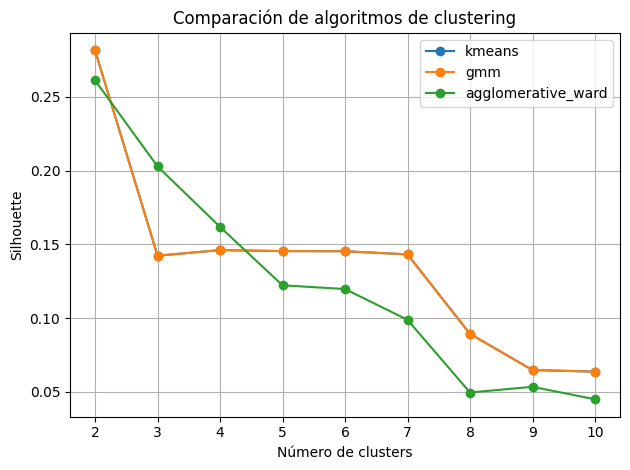

In [74]:
plt.figure()
for modelo in df_clust_results["modelo"].unique():
    subset = df_clust_results[df_clust_results["modelo"] == modelo]
    plt.plot(
        subset["n_clusters"],
        subset["silhouette"],
        marker="o",
        label=modelo,
    )

plt.xlabel("Número de clusters")
plt.ylabel("Silhouette")
plt.title("Comparación de algoritmos de clustering")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


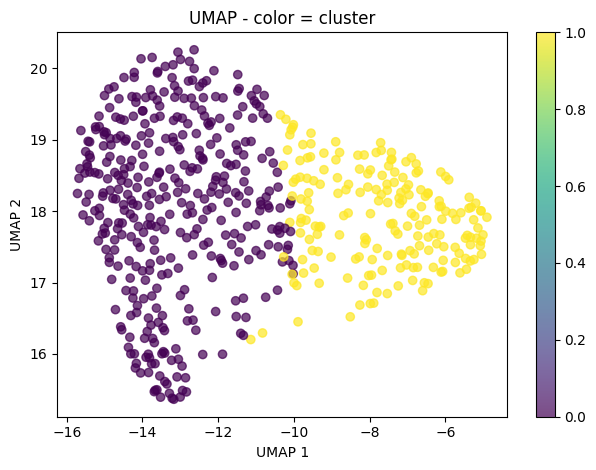

In [75]:
plot_umap(
    X_umap,
    color=meta_nm["cluster_auto"],
    title="UMAP - color = cluster"
)